## Data analysis

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
import pylab as plot


pd.options.display.max_columns = 100
params = {
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plot.rcParams.update(params)

In [2]:
import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv("../data/train.csv")
args.raw_test = pd.read_csv("../data/test.csv")
args.train_border_index = 891
args.val_border_index = 265
args.splits = 5
args.seed = 101

In [3]:
print(args.raw_train.describe())
print(args.raw_train.shape)
args.raw_train.head()

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(args.raw_test.describe())
print(args.raw_test.shape)
args.raw_test.head()

       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209    0.896760    0.981429   55.907576
min     892.000000    1.000000    0.170000    0.000000    0.000000    0.000000
25%     996.250000    1.000000   21.000000    0.000000    0.000000    7.895800
50%    1100.500000    3.000000   27.000000    0.000000    0.000000   14.454200
75%    1204.750000    3.000000   39.000000    1.000000    0.000000   31.500000
max    1309.000000    3.000000   76.000000    8.000000    9.000000  512.329200
(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Data spread

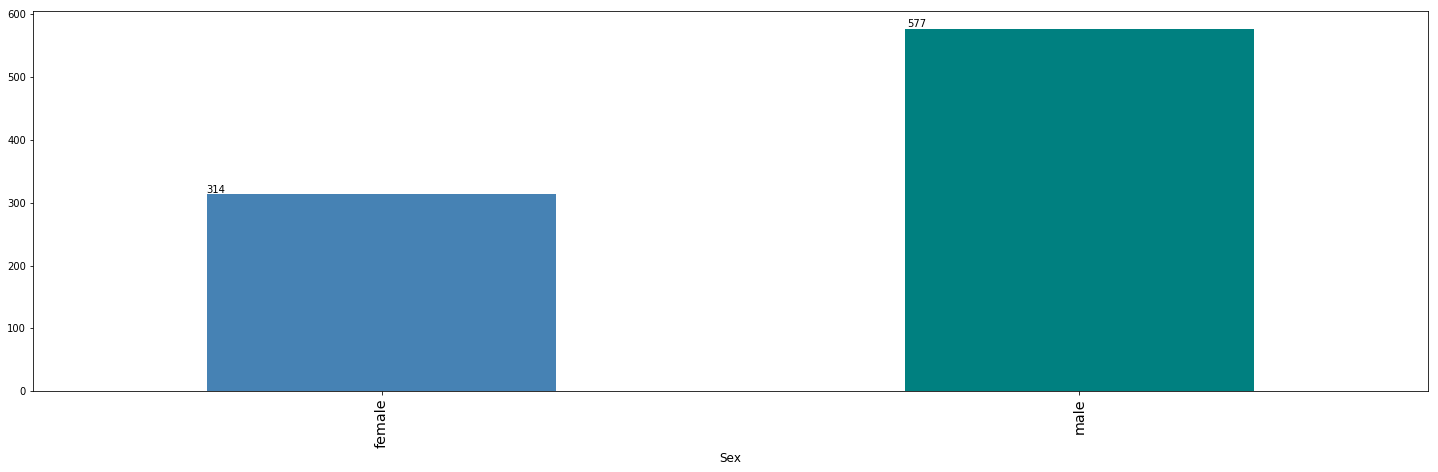

In [5]:
ax = args.raw_train.groupby(['Sex']).agg('count')['PassengerId'].plot(kind='bar', figsize=(25, 7),
                                                                   stacked=True, color=['SteelBlue', 'Teal'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

<Figure size 432x288 with 0 Axes>

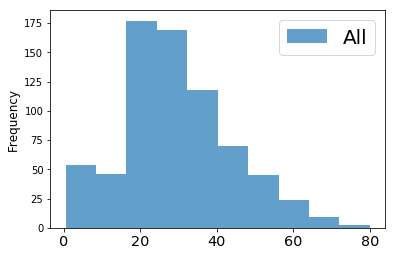

In [6]:
hist_data = pd.DataFrame({'All': args.raw_train['Age']}, columns=['All'])
plt.figure();
hist_data.plot.hist(alpha=0.7)

### Survived and sex

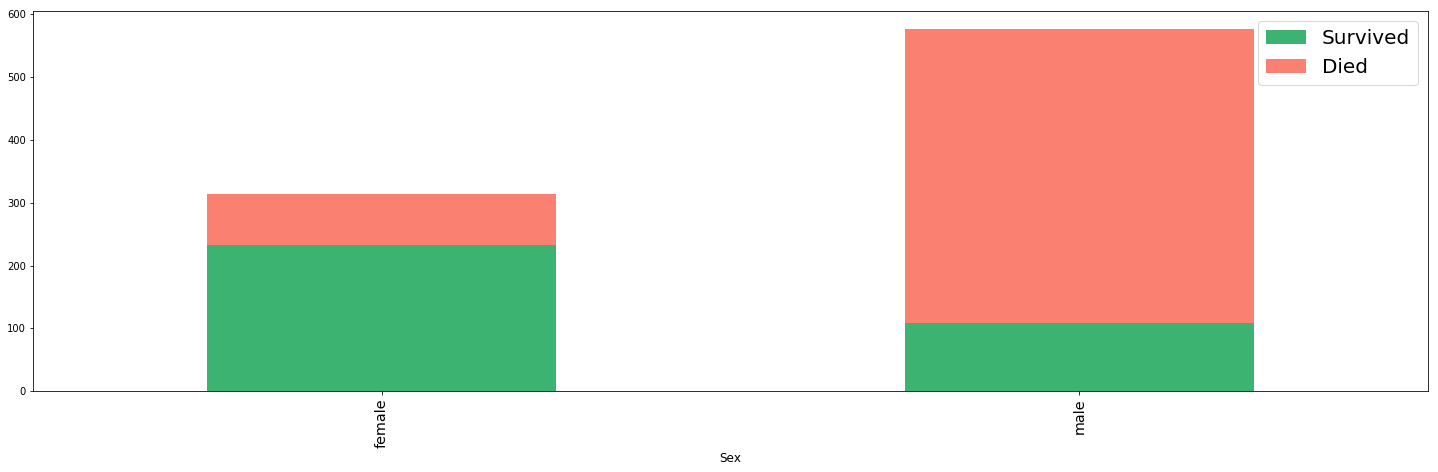

In [7]:
args.raw_train['Died'] = 1 - args.raw_train['Survived']
args.raw_train.groupby(['Sex']).agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                                   stacked=True, color=['MediumSeaGreen', 'Salmon'])

### Survived and age

<Figure size 432x288 with 0 Axes>

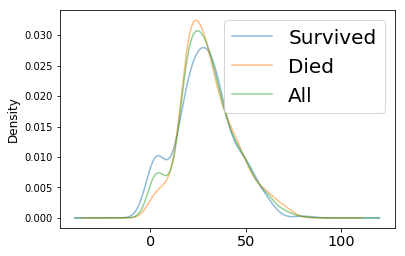

In [8]:
hist_data = pd.DataFrame({'Survived': args.raw_train['Age'][args.raw_train.Survived==1], 
                          'Died': args.raw_train['Age'][args.raw_train.Survived==0],
                          'All': args.raw_train['Age']}, columns=['Survived', 'Died', 'All'])
plt.figure();

hist_data.plot.kde(alpha=0.5)

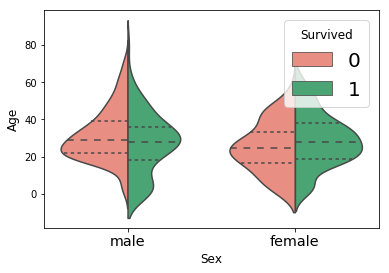

In [9]:
import seaborn as sns

sns.violinplot(x="Sex", y="Age", hue="Survived",
               split=True, inner="quart",
               palette={0: 'Salmon', 1: 'MediumSeaGreen'},
               data=args.raw_train)

### Survived and Pclass

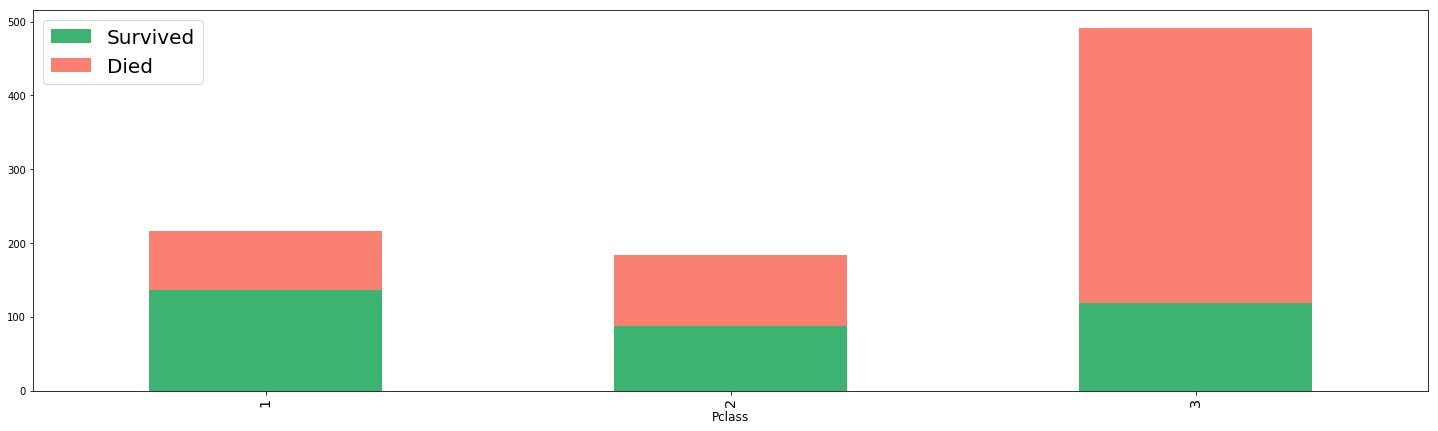

In [10]:
args.raw_train.groupby(['Pclass']).agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                                   stacked=True, color=['MediumSeaGreen', 'Salmon'])

### Survived and the number of siblings

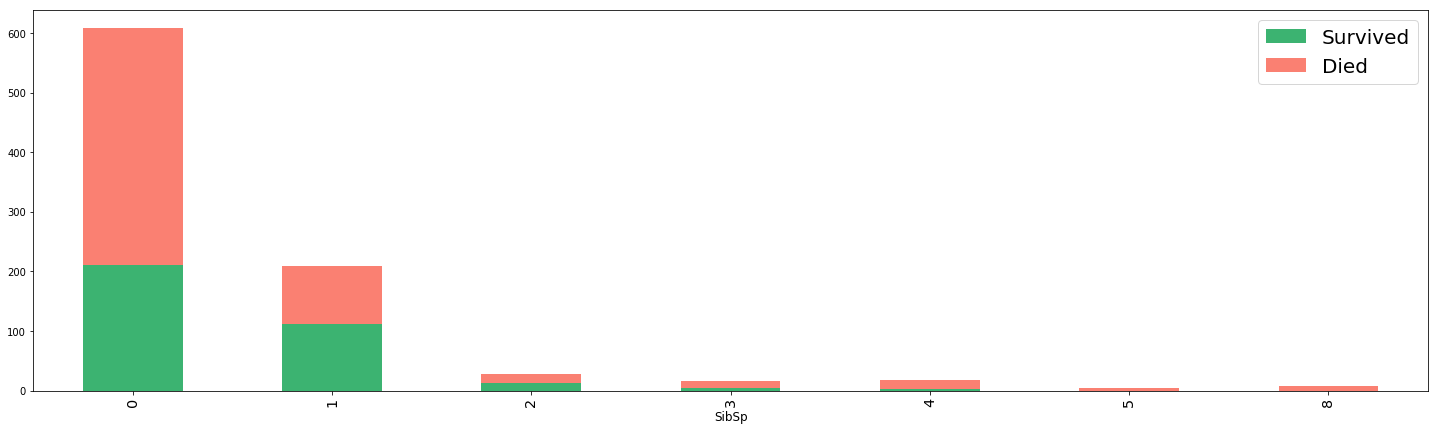

In [11]:
args.raw_train.groupby(['SibSp']).agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                                   stacked=True, color=['MediumSeaGreen', 'Salmon'])

### Survived and the number of parents and children

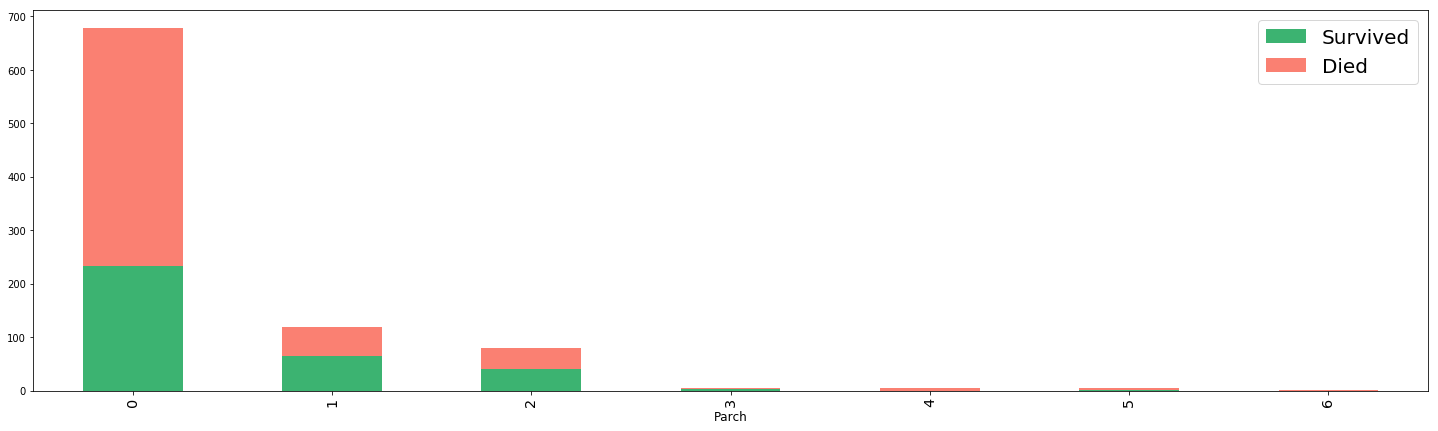

In [12]:
args.raw_train.groupby(['Parch']).agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                                   stacked=True, color=['MediumSeaGreen', 'Salmon'])

### Survived and embarked

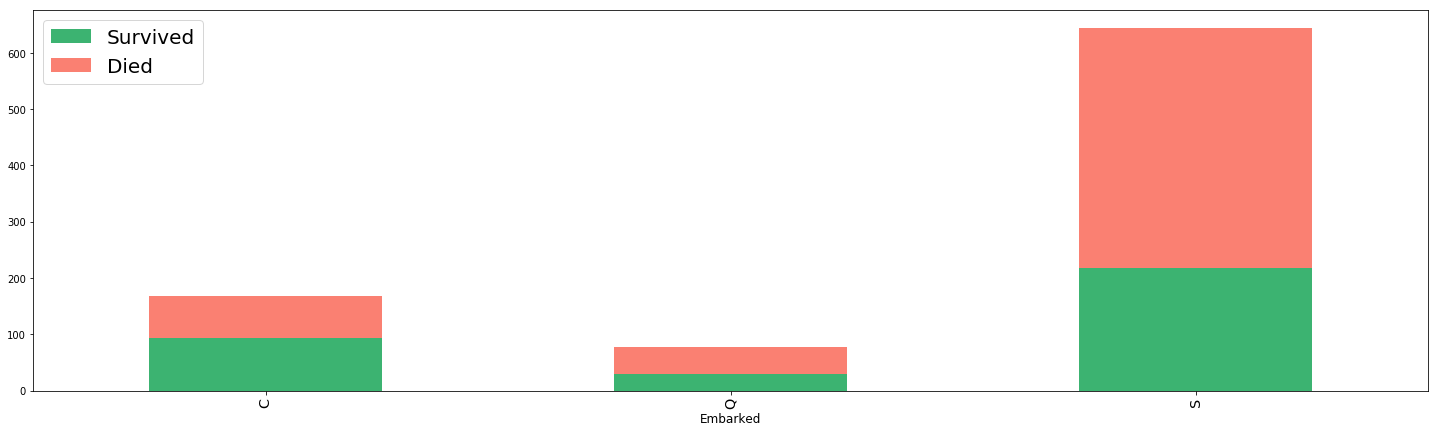

In [13]:
args.raw_train.groupby(['Embarked']).agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                                   stacked=True, color=['MediumSeaGreen', 'Salmon'])

In [14]:
args.raw_train.drop('Died', axis=1, inplace=True, errors = 'ignore')

### Unknown data

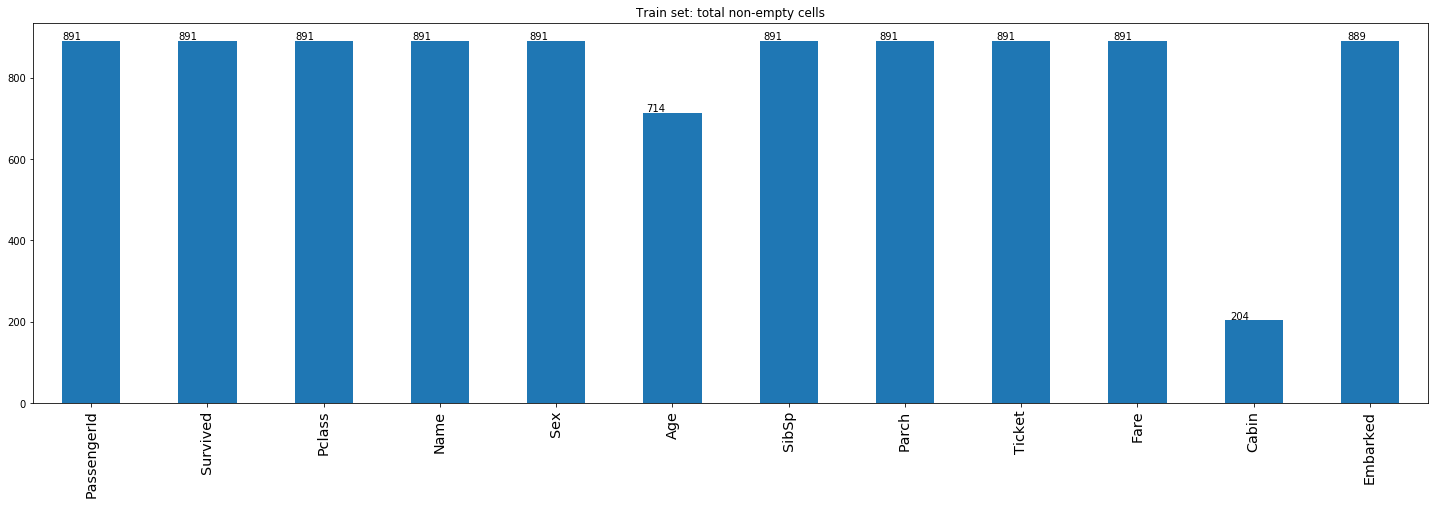

In [15]:
ax = args.raw_train.agg('count').plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total non-empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

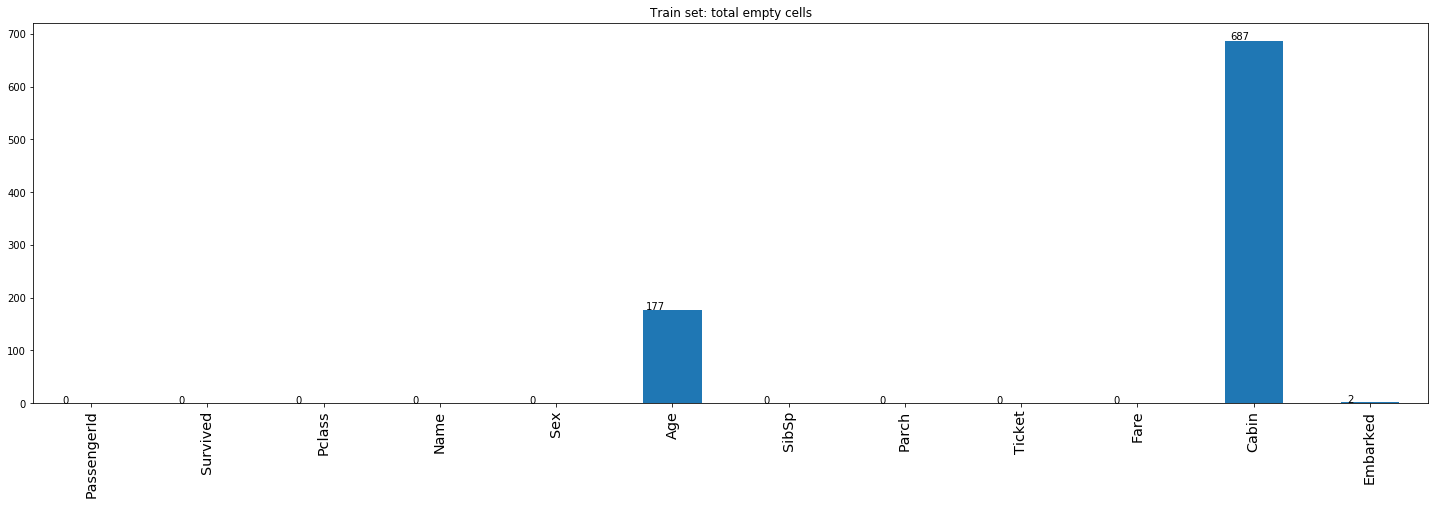

In [16]:
ax = args.raw_train.isna().sum().plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

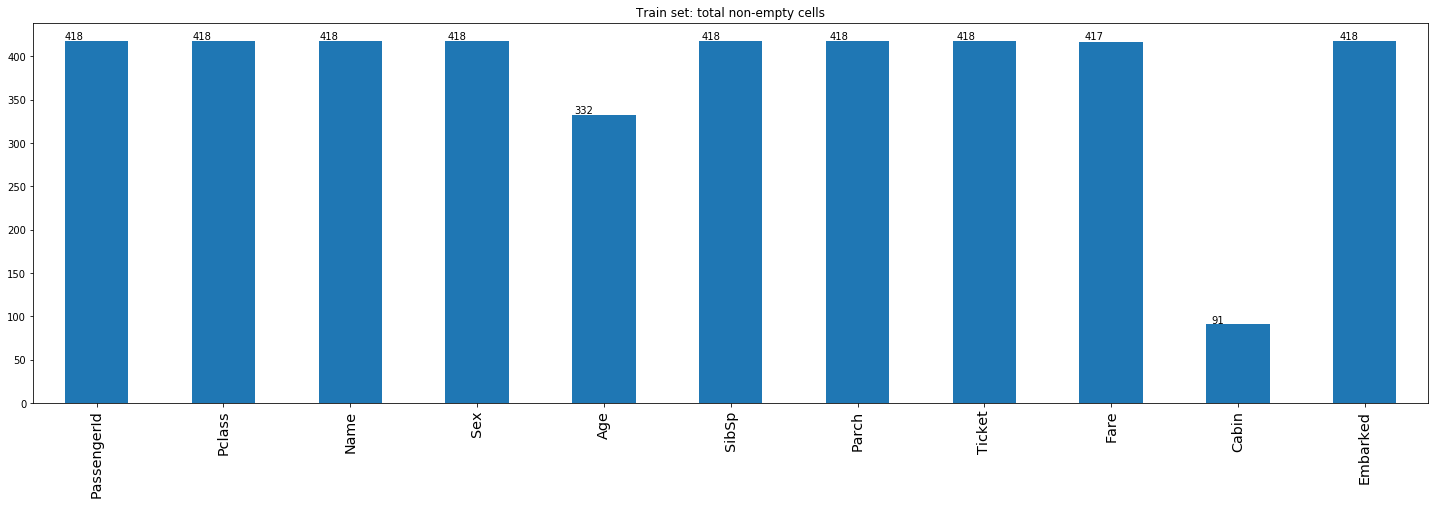

In [17]:
ax = args.raw_test.agg('count').plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total non-empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

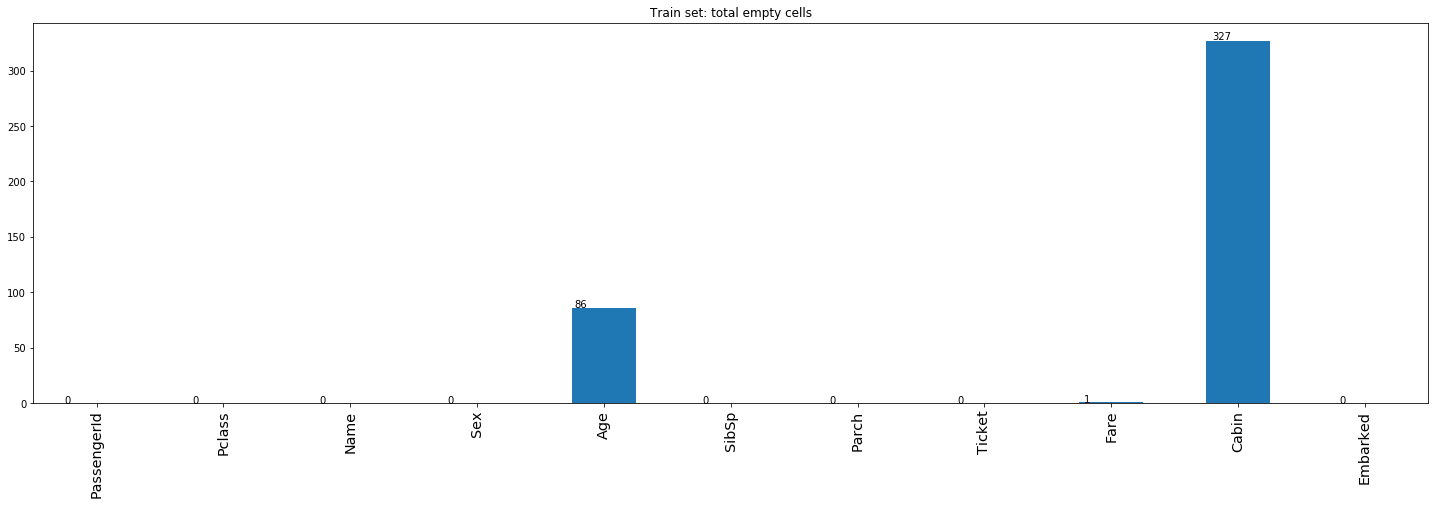

In [18]:
ax = args.raw_test.isna().sum().plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Filling missing data

In [19]:
train = args.raw_train.copy()
test = args.raw_test.copy()

#### Cabin

In [20]:
train.drop('Cabin', axis=1, inplace=True, errors = 'ignore')
test.drop('Cabin', axis=1, inplace=True, errors = 'ignore')

#### Embarked

In [21]:
most_frequent_embarked = train['Embarked'].value_counts().index[0]
train['Embarked'] = train['Embarked'].fillna(most_frequent_embarked)
train['Embarked'].isna().sum()

0

#### Age

In [22]:
train['Age'] = train['Age'].fillna(train['Age'].median())
test['Age'] = test['Age'].fillna(test['Age'].median())
print(train['Age'].isna().sum())
test['Age'].isna().sum()

0


0

#### Fare

In [23]:
test['Fare'] = test['Fare'].fillna(test['Fare'].median())
test['Fare'].isna().sum()

0

In [24]:
args.train_filled  = train.copy()
args.test_filled  = test.copy()

## Best discovered feature engineering

In [25]:
train  = args.train_filled.copy()
test  = args.test_filled.copy()

comb = train.append(test, ignore_index=True, sort=False)
comb.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


#### Transform name to title

In [26]:
title_dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir": "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess": "Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Royalty"
}
# map name to title
comb['Title'] = comb['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip()).map(title_dictionary)

# set a single value to Royalty manually
comb.loc[comb[comb['Title'].isnull()].index[0], 'Title'] = 'Royalty'
comb.drop('Name', axis=1, inplace=True)

#### Filling NA ages more carefully taking account of sex, pclass and title

In [27]:
import numpy as np

# get back the initial values for Age with nans
train_raw_ages = args.raw_train['Age']
test_raw_ages = args.raw_test['Age']

# fill this datasets separately to avoid info leak from the train set
train = comb[:args.train_border_index].copy()
test = comb[args.train_border_index:].reset_index(drop=True).copy()

train.drop('Age', axis=1, inplace=True, errors='ignore')
train = pd.concat([train, train_raw_ages], axis=1)
test.drop('Age', axis=1, inplace=True, errors='ignore')
test = pd.concat([test, test_raw_ages], axis=1)

def fill_age_median(dataset):
    median_ages = dataset.groupby(['Sex', 'Pclass', 'Title']).median().reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
    def fill_age_median_row(row):
        if np.isnan(row['Age']):
            return median_ages[(median_ages['Sex'] == row['Sex']) 
                              & (median_ages['Pclass'] == row['Pclass']) 
                              & (median_ages['Title'] == row['Title'])]['Age'].values[0]
        return row['Age']
    dataset['Age'] = dataset.apply(lambda row: fill_age_median_row(row), axis=1)

fill_age_median(train)
fill_age_median(test)
comb = train.append(test, ignore_index=True, sort=False)
comb.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Ticket,Fare,Embarked,Title,Age
0,1,0.0,3,male,1,0,A/5 21171,7.2500,S,Mr,22.0
1,2,1.0,1,female,1,0,PC 17599,71.2833,C,Mrs,38.0
2,3,1.0,3,female,0,0,STON/O2. 3101282,7.9250,S,Miss,26.0
3,4,1.0,1,female,1,0,113803,53.1000,S,Mrs,35.0
4,5,0.0,3,male,0,0,373450,8.0500,S,Mr,35.0


#### Remove PassengerId

In [28]:
comb.drop('PassengerId', axis=1, inplace=True, errors = 'ignore')

#### Encode sex

In [29]:
comb['Sex'] = comb['Sex'].astype('category').cat.codes

#### Encode Embarked

In [30]:
embarked_dummies = pd.get_dummies(comb['Embarked'], prefix='Embarked')
comb = pd.concat([comb, embarked_dummies], axis=1)
comb.drop('Embarked', axis=1, inplace=True)

#### Encode Pclass

In [31]:
pclass_dummies = pd.get_dummies(comb['Pclass'], prefix='Pclass')
comb = pd.concat([comb, pclass_dummies], axis=1)
comb.drop('Pclass', axis=1, inplace=True)

#### Encode ticket (make one digit?)

In [32]:
import re

def clean_ticket(ticket):
    # replace all special chars
    ticket = re.sub('[^a-zA-Z0-9]', '', ticket)
    if ticket[0].isdigit():
        return 'digit'
    return ticket[0] + ticket[1]

comb['Ticket'] = comb['Ticket'].map(clean_ticket)
ticket_dummies = pd.get_dummies(comb['Ticket'], prefix='Ticket')
comb = pd.concat([comb, ticket_dummies], axis=1)
comb.drop('Ticket', axis=1, inplace=True)

#### Encode title

In [33]:
ticket_dummies = pd.get_dummies(comb['Title'], prefix='Title')
comb = pd.concat([comb, ticket_dummies], axis=1)
comb.drop('Title', axis=1, inplace=True)

In [34]:
comb.head()

,Survived,Sex,SibSp,Parch,Fare,Age,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Ticket_A2,Ticket_A4,Ticket_A5,Ticket_AQ,Ticket_AS,Ticket_C1,Ticket_C4,Ticket_C7,Ticket_CA,Ticket_FC,Ticket_Fa,Ticket_LI,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_SC,Ticket_SO,Ticket_SP,Ticket_ST,Ticket_SW,Ticket_WC,Ticket_WE,Ticket_digit,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,0.0,1,1,0,7.2500,22.0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1.0,0,1,0,71.2833,38.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1.0,0,0,0,7.9250,26.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,1.0,0,1,0,53.1000,35.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0.0,1,0,0,8.0500,35.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


#### Transform the number of parents and siblings to family size

In [35]:
def fill_family_size(comb, s_size=0, m_size=4):
    def fill_family_size_row(row):
        if row['SibSp'] + row['Parch'] == s_size:
            return 's'
        elif row['SibSp'] + row['Parch'] <= m_size:
            return 'm'
        else:
            return 'l'
    comb['FamilySize'] = comb.apply(lambda row: fill_family_size_row(row), axis=1)
    
fill_family_size(comb)

family_size_dummies = pd.get_dummies(comb['FamilySize'], prefix='FamilySize')
comb = pd.concat([comb, family_size_dummies], axis=1)
comb.drop('FamilySize', axis=1, inplace=True)
comb.drop('SibSp', axis=1, inplace=True)
comb.drop('Parch', axis=1, inplace=True)

#### MinMax scaling

In [36]:
import pandas as pd
from sklearn import preprocessing

def min_max_scale(comb):
    temp = comb.values #a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    temp = min_max_scaler.fit_transform(temp)
    return pd.DataFrame(temp, columns=comb.columns)

comb = min_max_scale(comb)
comb.head()

,Survived,Sex,Fare,Age,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Ticket_A2,Ticket_A4,Ticket_A5,Ticket_AQ,Ticket_AS,Ticket_C1,Ticket_C4,Ticket_C7,Ticket_CA,Ticket_FC,Ticket_Fa,Ticket_LI,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_SC,Ticket_SO,Ticket_SP,Ticket_ST,Ticket_SW,Ticket_WC,Ticket_WE,Ticket_digit,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,FamilySize_l,FamilySize_m,FamilySize_s
0,0.0,1.0,0.014151,0.273456,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.139136,0.473882,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.015469,0.323563,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.103644,0.436302,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.015713,0.436302,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Train baseline model

In [37]:
train = comb[:args.train_border_index]
X = train.drop('Survived', axis=1)
y = train['Survived']
test = comb[args.train_border_index:].reset_index(drop=True)
X_test = test.drop('Survived', axis=1)
args.X = X.copy()
args.y = y.copy()
args.X_test = X_test.copy()

In [38]:
X.head()

,Sex,Fare,Age,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Ticket_A2,Ticket_A4,Ticket_A5,Ticket_AQ,Ticket_AS,Ticket_C1,Ticket_C4,Ticket_C7,Ticket_CA,Ticket_FC,Ticket_Fa,Ticket_LI,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_SC,Ticket_SO,Ticket_SP,Ticket_ST,Ticket_SW,Ticket_WC,Ticket_WE,Ticket_digit,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,FamilySize_l,FamilySize_m,FamilySize_s
0,1.0,0.014151,0.273456,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.139136,0.473882,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.015469,0.323563,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.103644,0.436302,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.015713,0.436302,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [39]:
def csv_predictions(predictions, filename):
    submission = pd.DataFrame({'PassengerId': args.raw_test['PassengerId'],'Survived': predictions})

    submission.to_csv(filename, index=False)
    print('Saved file: ' + filename)

#### SVM

In [46]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

def predict_svm(X, y, X_test, splits=args.splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=args.seed)
    parameters = {'C': [0.01, 1], 'gamma': [0.01, 1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
    classifier = SVC(random_state=args.seed)
    gcv = GridSearchCV(classifier, parameters, n_jobs=-1, cv=skf, verbose=3)
    gcv.fit(X, y)
    best_params = gcv.best_params_
    print('SVM best params: ' + repr(gcv.best_params_))
    print('SVM best CV score: ' + repr(gcv.best_score_))
    
    predictions = gcv.best_estimator_.predict(X_test)
    return predictions.astype(int)

predictions = predict_svm(X, y, X_test)
csv_predictions(predictions, '../predictions/titanic-experiments-svm.csv')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    1.4s


SVM best params: {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}
SVM best CV score: 0.8170594837261503
Saved file: titanic-experiments-svm.csv


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.7s finished
/Users/mkhokhlush/github/titanic-prediction/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Random forest

In [50]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def predict_random_forest(X, y, X_test, splits=args.splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=args.seed)
    parameters = {'n_estimators': [30, 40, 50, 60], 'max_features': [7, 11, 15],
              'min_samples_leaf': [3, 5, 7], 'max_depth': [20, 30]}
    classifier = RandomForestClassifier(random_state=args.seed, n_jobs=-1, oob_score=True)
    gcv = GridSearchCV(classifier, parameters, n_jobs=-1, cv=skf, verbose=1)
    gcv.fit(X, y)
    best_params = gcv.best_params_
    print('RandomForest best params: ' + repr(gcv.best_params_))
    print('RandomForest best CV score: ' + repr(gcv.best_score_))
    print('RandomForest best oob score: ' + repr(gcv.best_estimator_.oob_score_))
    
    predictions = gcv.best_estimator_.predict(X_test)
    return predictions.astype(int)

predictions = predict_random_forest(X, y, X_test)
csv_predictions(predictions, '../predictions/titanic-experiments-random-forest.csv')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   14.2s finished


RandomForest best params: {'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 5, 'n_estimators': 30}
RandomForest best CV score: 0.8361391694725028
RandomForest best oob score: 0.8249158249158249
Saved file: titanic-experiments-random-forest.csv


#### Extra trees

In [55]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

def predict_extra_trees(X, y, X_test, splits=args.splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=args.seed)
    parameters = {'n_estimators': [10, 25, 50], 'max_features': [7, 11, 15],
                  'min_samples_leaf': [3, 5, 7],
                  'max_depth': [10, 20, 30]}
    classifier = ExtraTreesClassifier(random_state=args.seed, n_jobs=-1)
    gcv = GridSearchCV(classifier, parameters, n_jobs=-1, cv=skf, verbose=1)
    gcv.fit(X, y)
    best_params = gcv.best_params_
    print('ExtraTrees best params: ' + repr(gcv.best_params_))
    print('ExtraTrees best CV score: ' + repr(gcv.best_score_))
#     print('ExtraTrees best oob score: ' + repr(gcv.best_estimator_.oob_score_))
    
    predictions = gcv.best_estimator_.predict(X_test)
    return predictions.astype(int)

predictions = predict_extra_trees(X, y, X_test)
csv_predictions(predictions, '../predictions/titanic-experiments-extra-trees.csv')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   15.3s finished


ExtraTrees best params: {'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10}
ExtraTrees best CV score: 0.8271604938271605
Saved file: titanic-experiments-extra-trees.csv


#### XGBoost

In [58]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier

def predict_xgboost(X, y, X_test, splits=args.splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=args.seed)
    parameters = {'n_estimators': [10, 25, 50], 'max_depth': [7, 15, 25],
                  'learning_rate': [0.01, 0.1], 'booster': ['gbtree', 'gblinear', 'dart']}
    classifier = XGBClassifier()
    gcv = GridSearchCV(classifier, parameters, n_jobs=-1, cv=skf, verbose=1)
    gcv.fit(X, y)
    best_params = gcv.best_params_
    print('XGBoost best params: ' + repr(gcv.best_params_))
    print('XGBoost best CV score: ' + repr(gcv.best_score_))
    print('XGBoost feature importance: ' + repr(gcv.best_estimator_.feature_importances_))
    predictions = gcv.best_estimator_.predict(X_test)
    return predictions.astype(int)

predictions = predict_xgboost(X, y, X_test)
csv_predictions(predictions, '../predictions/titanic-experiments-xgboost.csv')

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


XGBoost best params: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 25}
XGBoost best CV score: 0.8383838383838383
XGBoost feature importance: array([0.09664966, 0.00891324, 0.0068668 , 0.00281166, 0.00539058,
       0.00567282, 0.02212608, 0.00511842, 0.08804722, 0.        ,
       0.        , 0.0040469 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00914777, 0.        , 0.        ,
       0.        , 0.        , 0.00339464, 0.        , 0.        ,
       0.00193107, 0.        , 0.00911832, 0.        , 0.        ,
       0.        , 0.00464866, 0.00952467, 0.00714041, 0.5998598 ,
       0.00663981, 0.07609288, 0.009002  , 0.00995678, 0.00383769,
       0.00406216], dtype=float32)
Saved file: titanic-experiments-xgboost.csv


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    3.5s finished


#### MLP

In [60]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier

def predict_mlp(X, y, x, splits=args.splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=args.seed)
    parameters = {'hidden_layer_sizes': [(512, ), (128, ), (16, ), (512, 64, ), (128, 16), (16, 4)],
                  'alpha': [0.01, 0.1], 'max_iter': [10, 25, 50],
                  'early_stopping': [False, True]}
    classifier = MLPClassifier(random_state=args.seed)
    gcv = GridSearchCV(classifier, parameters, n_jobs=-1, cv=skf, verbose=3)
    gcv.fit(X, y)
    best_params = gcv.best_params_
    print('MLP best params: ' + repr(gcv.best_params_))
    print('MLP best CV score: ' + repr(gcv.best_score_))
    
    predictions = gcv.best_estimator_.predict(X_test)
    return predictions.astype(int)

predictions = predict_mlp(X, y, X_test)
csv_predictions(predictions, '../predictions/titanic-experiments-mlp.csv')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 349 out of 360 | elapsed:   26.0s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.2s finished


MLP best params: {'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (128,), 'max_iter': 50}
MLP best CV score: 0.8294051627384961
Saved file: ../predictions/titanic-experiments-mlp.csv


/Users/mkhokhlush/github/titanic-prediction/venv/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### Test score

|  Model | CV score |
|---|---|
| Extra trees  |  0.78468 |
| Random forest | 0.76076 |
| MLP | 0.78229 |
| XGBoost | 0.75119 |
| SVM | 0.77033 |

## Experiments

#### Pipelines

In [66]:
train_pipeline = args.raw_train.copy()
test_pipeline = args.raw_test.copy()
train_pipeline.drop('Cabin', axis=1, inplace=True, errors = 'ignore')
test_pipeline.drop('Cabin', axis=1, inplace=True, errors = 'ignore')
train_pipeline.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [ ]:
train_most_freq_attr = train['Embarked']
train_age_attr = train['Age']
test_age_attr = test['Age']
test_fare_attr = test['Fare']